In [1]:
import os
import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFAlbertModel


In [2]:
data_root = '../data/'
local_zip = data_root + 'ner_datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(data_root)
zip_ref.close()


In [3]:
max_len = 150
batch_size = 32
model_name = 'clue/albert_chinese_tiny'
saved_model = 'ner_albert_tiny_token_input'


In [4]:
def get_data_path(dataset='mara', type='train'):
    data_dir = data_root + 'ner_datasets/' + dataset
    if type in ['train', 'val', 'test'] and dataset in ['msra', 'daily', 'weibo']:
        sentences = os.path.join(data_dir, type, 'sentences.txt')
        labels = os.path.join(data_dir, type, 'labels.txt')
        return sentences, labels
    else:
        raise ValueError(
            "data type not in ['train', 'val', 'test'] or dataset name not in ['msra', 'daily', 'weibo']")


In [5]:
datasets = ['msra', 'daily']


def get_combined_dataset(type):
    sentences_datasets = None
    labels_datasets = None
    for dataset in datasets:
        sen_file, labels_file = get_data_path(dataset, type)
        sentences = tf.data.TextLineDataset(sen_file)
        labels = tf.data.TextLineDataset(labels_file)
        sentences_datasets = sentences if sentences_datasets is None else sentences_datasets.concatenate(
            sentences)
        labels_datasets = labels if labels_datasets is None else labels_datasets.concatenate(
            labels)
    return tf.data.Dataset.zip((sentences_datasets, labels_datasets))


In [6]:
class Sentence_Tokenizer(object):
    def __init__(self, model_name, max_length=128, padded_token=True):
        super().__init__()
        self.max_length = max_length
        self.padded_token = padded_token
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

    def bert_pack_inputs(self, sentences):
        input_ids = []
        attention_masks = []
        token_type_ids = []
        for sentence in sentences:
            tokens = self.tokenize(sentence, self.padded_token)
            input_ids.append(tokens['input_ids'])
            attention_masks.append(tokens['attention_mask'])
            token_type_ids.append(tokens['token_type_ids'])
        return [tf.constant(input_ids), tf.constant(token_type_ids), tf.constant(attention_masks)]

    def tokenize(self, sentence, padded_token=True):
        padiding = 'max_length' if padded_token else True
        tokens = self.tokenizer(text=sentence.strip(
        ), max_length=self.max_length, truncation=True, padding=padiding, add_special_tokens=True)
        return tokens

    def decode(self, tokens):
        words = self.tokenizer.decode(tokens)
        return words


tokenizer = Sentence_Tokenizer(model_name, max_length=max_len)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [7]:
class Label_Tokenizer(object):
    def __init__(self, labels, max_length):
        super().__init__()
        self.size = len(labels)
        labels_to_ids = {k: v for v, k in enumerate(labels)}
        ids_to_labels = {v: k for v, k in enumerate(labels)}
        self.labels_to_ids = labels_to_ids
        self.ids_to_labels = ids_to_labels
        self.max_length = max_length

    def tokenize(self, labels):
        tokens = [self._tokenize(label) for label in labels]
        return tokens

    def _tokenize(self, label):
        label = label.decode('utf-8') if hasattr(label, 'decode') else label
        labels = [le for le in label.strip().split(' ')]
        special_token = self.encode(['O'])[0]

        tokens = self.encode(labels)
        tokens = tokens[:self.max_length - 2]
        tokens = [special_token] + tokens + [special_token]
        # Add padded TAG tokens
        padding_len = self.max_length - len(tokens)
        tokens = tokens + ([special_token] * padding_len)
        return tokens

    def encode(self, labels):
        return [self.labels_to_ids[label] for label in labels]

    def decode(self, ids):
        return [self.ids_to_labels[id] for id in ids]


labels = ['O', 'B-ORG', 'I-PER', 'B-PER', 'I-LOC', 'I-ORG', 'B-LOC']
label_tokenizer = Label_Tokenizer(labels, max_length=max_len)
labels_num = label_tokenizer.size


In [8]:
def get_type_data(type, max_lines=None):
    datasets = get_combined_dataset(type)

    if(max_lines != None):
        datasets = datasets.take(max_lines)

    datasets.shuffle(10000, reshuffle_each_iteration=False)

    xs = []
    ys = []

    for dataset in datasets.as_numpy_iterator():
        sentence = dataset[0]
        label = dataset[1]
        xs.append(sentence.decode('utf-8'))
        ys.append(label.decode('utf-8'))

    x = tokenizer.bert_pack_inputs(xs)
    y = label_tokenizer.tokenize(ys)
    y = tf.constant(y)

    print(len(y))
    return x, y


In [9]:
x_train, y_train = get_type_data('train')
x_val, y_val = get_type_data('val')
x_test, y_test = get_type_data('test')


2022-06-22 22:23:54.152193: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


62864
5318
8078


In [10]:
def create_model(labels_num, max_lenth):
    input_ids = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)
    token_type_ids = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)
    attention_mask = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)

    encoder = TFAlbertModel.from_pretrained(model_name, from_pt=True)
    outputs = encoder(
        input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )

    embedding = outputs[0]
    embedding = keras.layers.Dropout(0.1)(embedding)
    tag_logits = keras.layers.Dense(
        labels_num + 1, activation='softmax', name='NER')(embedding)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = tf.metrics.SparseCategoricalAccuracy(name='accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


In [11]:
model = create_model(labels_num, max_lenth=max_len)
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  4080520    ['input_1[0][0]',                
 )                              thPooling(last_hidd               'input_3[0][0]',            

In [12]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=3,
    verbose=1,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)


Epoch 1/3


/Users/mng/miniforge3/envs/c3-nlp/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1965/1965 [==============================] - 1206s 613ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.0186 - val_accuracy: 0.9939
Epoch 2/3
1965/1965 [==============================] - 1223s 623ms/step - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.0148 - val_accuracy: 0.9951
Epoch 3/3
1965/1965 [==============================] - 1232s 627ms/step - loss: 0.0102 - accuracy: 0.9967 - val_loss: 0.0104 - val_accuracy: 0.9967


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


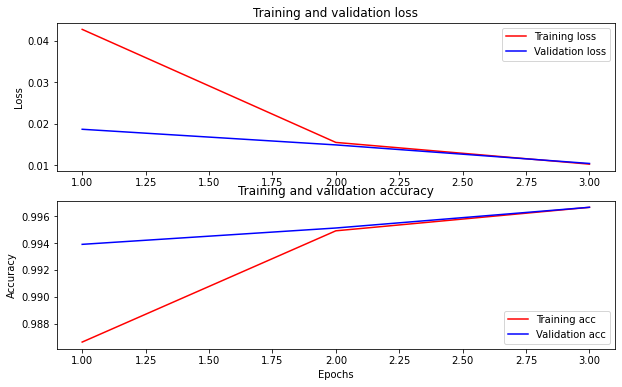

In [13]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [14]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


253/253 [==============================] - 69s 274ms/step - loss: 0.0124 - accuracy: 0.9962
Loss: 0.012383039109408855
Accuracy: 0.9961962699890137


In [15]:
def predict_from_text(text, model):
    n_tokens = len(tokenizer.tokenize(text, padded_token=False)['input_ids'])
    tokens = tokenizer.bert_pack_inputs([text])
    x_test = tokens
    pred_test = model.predict(x_test) if hasattr(
        model, 'predict') else model(x_test)
    # ignore predictions of padding tokens
    pred_tags = np.argmax(pred_test, 2)[0][:n_tokens]

    tags = label_tokenizer.decode(pred_tags)
    res = []
    words = {
        'word': '',
        'tag': None
    }
    for idx, tag in enumerate(tags):
        if(tag != 'O'):
            pre, suf = tag.split('-')
            words['tag'] = suf
            token = x_test[0][0][idx]
            token = token.numpy()
            word = tokenizer.decode(token)
            # word = preprocessor.decode(word)
            words['word'] = words['word'] + word if words['word'] else word
        else:
            if(words['tag']):
                res.append(words)
            words = {
                'word': '',
                'tag': None
            }
    return pd.DataFrame(res)


In [16]:
test_inputs = '李华住在朝阳区香河园街道西坝河北里社区，在5月4号去过天安门广场，5号下午去了太阳宫凯德茂商场。'


In [17]:
print(predict_from_text(test_inputs, model))


              word  tag
0               李华  PER
1  朝阳区香河园街道西坝河北里社区  LOC
2            天安门广场  LOC
3         太阳宫凯德茂商场  LOC


In [18]:
model.save(saved_model, include_optimizer=False)


2022-06-22 23:26:38.419428: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ner_albert_tiny_token_input/assets


INFO:tensorflow:Assets written to: ner_albert_tiny_token_input/assets
